In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем модуль pprint для красивого вывода данных на экран
import pprint


# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Хи квадрат
from sklearn.feature_selection import chi2

# ANOVA
from sklearn.feature_selection import f_classif

# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем модуль для работы с геоданными
from geopy import Yandex

# Загружаем модуль для работы с регулярными выражениями
import re

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

# Загружаем библиотеку для обработки естественного языка
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# поменяем некоторые свойства pandas, чтобы данные полностью выводились на экран
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)

# Постановка задачи

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

# Знакомство с данными

__Файлы для соревнования__:

* hotels_train.csv - набор данных для обучения
* hotels_test.csv - набор данных для оценки качества
* submission.csv - файл сабмишна в нужном формате

__Признаки__:

* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля

In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

Прочитаем данные и выведем несколько строк получившегося датасета.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443


In [10]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# Обработка данных

Проверим датасет __df_train__ на наличие дубликатов и пропусков

In [12]:
# выведем количество пропусков
dublicated_rows = df_train.duplicated().sum()
print(f'Количетво дублирущихся строк: {dublicated_rows}')

Количетво дублирущихся строк: 307


In [13]:
# Очистим датасет df_train от дубликатов
df_train = df_train.drop_duplicates()

In [14]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
# выведем данные получившегося датасета
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [16]:
# Проверим датасет на пропуски  и выведем признаки, в которых имеются пропуски, а также количество пропусков
print('Признаки с пропусками:')
data.isna().sum()[data.isna().sum() > 0]

Признаки с пропусками:


lat    3268
lng    3268
dtype: int64

Пропуски имеются только в признаках координат. Для заполнения этих пропусков определим адреса отелей, у которых отсутствуют координаты, и при помощи библиотеки geopy найдем координаты по адресу отеля.

In [17]:
# создадим список адресов отелей, у которых отсутвуют координаты
mask = (data['lat'].isnull()) | (data['lng'].isnull())
hotel_addresses = data[mask]['hotel_address'].unique()

In [18]:
# воспользуемся библиотекой geopy для заполения отсутствующих координат
# сначала создадим словарь, где ключом будет адрес, а значениями ключа - долгота и широта

missing_coordinates = {
 '20 Rue De La Ga t 14th arr 75014 Paris France': [48.838331, 2.330948],
 '23 Rue Damr mont 18th arr 75018 Paris France': [48.856663, 2.351556],
 '4 rue de la P pini re 8th arr 75008 Paris France': [48.856663, 2.351556],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.396133, 1.655829],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.222139, 16.357513],
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': [48.778035, 15.65565],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.210918, 16.347119],
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': [48.210918, 16.347119],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.206487, 16.36346],
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': [48.176599, 16.413999],
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': [41.504994, 2.245959],
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': [48.211783, 16.297308],
 'Sep lveda 180 Eixample 08011 Barcelona Spain': [41.425226, 2.181864],
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': [48.245935, 16.341397],
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': [48.218213, 16.39411],
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': [48.222139,16.357513],
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': [48.222139, 16.357513]
}

# missing_coordinates = {}

#for address in hotel_addresses:
#    location = Yandex(api_key='xxx').geocode(address)
#    missing_coordinates[address] = [location.latitude, location.longitude]

__Комментарий__

Для получения координат нужно подставить свой api ключ вот в эту строчку вместо xxx: __location = Yandex(api_key='xxx').geocode(address)__. Ключ можно получить здесь - https://developer.tech.yandex.ru/
Пропущенные координаты были получены имеено таким путем:

for address in hotel_addresses:

       location = Yandex(api_key='xxx').geocode(address) 
   
       missing_coordinates[address] = [location.latitude, location.longitude]

In [19]:
# выведем получившийся словарь    
# pprint.pprint(missing_coordinates)

In [20]:
# заполним отсутствующие координаты
for address in hotel_addresses:
    mask1 = (data['lat'].isnull()) | (data['lng'].isnull())
    mask2 = data['hotel_address'] == address
    data.loc[mask1 & mask2, 'lat'] = missing_coordinates[address][0]
    data.loc[mask1 & mask2, 'lng'] = missing_coordinates[address][1]

In [21]:
# проверим, остались ли еще пропуски
print('Признаки с пропусками:')
data.isna().sum()[df_train.isna().sum() > 0]

Признаки с пропусками:


lat    0
lng    0
dtype: int64

In [22]:
# выведем данные датасета после очистки
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [23]:
# выведем количество уникальных значение каждого признака
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1485
lng                                             1485
sample                                             2
reviewer_score                                    38
dtype: int64

# Создание признаков

In [24]:
# создадим дополнительные признаки hotel_city (город, где находится отель) и 'hotel_country' (страна, где находится отель). Эту информацию получим из признака hotel_address
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-2] != 'United' else ' '.join(x.split()[-2:]))
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-2] if 'London' not in x else 'London')

In [25]:
# создадим признак, в которому укажем, является ли постоялец резидентом  в стране нахождения отеля
data['is_resident'] = data['hotel_country'].str.strip() == data['reviewer_nationality'].str.strip()

In [26]:
# Приведем review_date в датасете к формату даты
data['review_date'] = data['review_date'].astype('datetime64[ns]')

# создадим новые признаки из даты, а именно признак дня недели (review_weekday), месяца (review_month) и года (review_year)
data['review_weekday'] = data['review_date'].dt.day_name()
data['review_month'] = data['review_date'].dt.month_name()
data['review_year'] = data['review_date'].dt.year

# дополнительно создадим признак сезона
seasons_dict = {
    'December': 'winter', 
    'January': 'winter', 
    'February': 'winter',
    'March': 'spring',
    'April' : 'spring',
    'May': 'spring',
    'June': 'summer',
    'July': 'summer',
    'August': 'summer',
    'September': 'autumn',
    'October': 'autumn',
    'November': 'autumn'
}

data['review_season'] = data['review_month'].apply(lambda x: seasons_dict[x])

In [27]:
# создадим признак, где бы отображалось количество проведенных в отеле ночей. Для этого используем информацию из тегов, имеющих вид Stayed XX nigths

# при помощи регулярных выражений вычленим количество проведенных в отеле ночей в отдельный признак
reqex = 'Stayed\s\d{1,2}'
data['stayed_nights'] = pd.to_numeric(data['tags'].str.findall(reqex).str.get(0).str.findall('\d{1,2}').str.get(0), errors='coerce')

# выведем количество отзывов, где не указано число проведенных в отеле ночей
nan_values = data['stayed_nights'].isnull().sum()
print(f'Количество постояльцев, которые не указали количество проведенных в отеле ночей: {nan_values}')


Количество постояльцев, которые не указали количество проведенных в отеле ночей: 192


In [28]:
# заполним пропуски в данных о количестве проведенных ночей, используя среднее значение
data['stayed_nights'] = data['stayed_nights'].fillna(data['stayed_nights'].mean())

# поменяем тип данных на целочисленный
data['stayed_nights'] = data['stayed_nights'].astype('int')

In [29]:
# сделаем словарь тегов, и для 10 самых популярных из них создадим отдельные признаки:

unique_tags = {}

for tags in data['tags'].values:
    tags_text = tags.strip('[]')
    tags_list = tags_text.split(', ')
    tags_list = [element.strip("'").strip() for element in tags_list]
    for tag in tags_list:
        if tag in unique_tags.keys():
            unique_tags[tag] += 1
        else:
            unique_tags[tag] = 1

# сделаем из получившегося словаря датасет
tags_df = pd.DataFrame(unique_tags.items(), columns=['tag_name', 'number_of_entries'])

# выведем первые 10 самых популярных тега, кроме тех, где упоминается про количество впроведенных ночей - эти данные уже были использованы для создания новых признаков
most_popular_tags = tags_df[~tags_df['tag_name'].str.contains('Stayed')].sort_values(by = 'number_of_entries', ascending = False).head(10)
most_popular_tags

,tag_name,number_of_entries
0,Leisure trip,417538
10,Submitted from a mobile device,307470
1,Couple,252128
8,Solo traveler,108476
7,Business trip,82884
4,Group,65361
31,Family with young children,60989
2,Double Room,35207
28,Standard Double Room,32247
19,Superior Double Room,31361


In [30]:
# изменим признак tags, чтобы в нем содержался список тегов. Сейчас теги имеют формат строки.
# создадим функцию для преобразования строки с тегами в список

def tags_to_list_converter(tag):
    tags_text = tag.strip('[]')
    tags_list = tags_text.split(', ')
    tags_list = [element.strip("'").strip() for element in tags_list]
    return tags_list

# применим функцию
data['tags'] = data['tags'].apply(tags_to_list_converter)

In [31]:
# теперь создадим признаки для десяти самых популяных тегов. Признаки будут показывать, имеется ли данный тег в отзыве (принимать значение 1, если тег имеется, и 0 - если нет)

for tag in most_popular_tags['tag_name'].values:
    data['is_'+ tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)


In [32]:
# воспользуемся бибиотекой для обработки естественного языка и проанализируем позитивные и негативные отзывы.
# результаты анализа занесем в два новых признака positive_review_score и negative_review_score
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

data['positive_review_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
data['negative_review_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Кодирование признаков

In [33]:
# закодируем столбцы 'hotel_country', 'hotel_city', 'is_resident', 'review_weekday', 'review_month', 'review_year', 'review_season' при помощи pd.get_dummies

columns_to_code = ['hotel_country', 'hotel_city', 'is_resident', 'review_weekday', 'review_month', 'review_year', 'review_season']

data = pd.get_dummies(data, columns=columns_to_code, dtype=int)

In [34]:
# закодируем признак 'reviewer_nationality' при помощи двоичного кодирования (количество уникальных значений национальности составляет 227)
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['reviewer_nationality'],axis=1,inplace=True)

In [35]:
# закодируем признак 'hotel_name' при помощи двоичного кодирования (количество уникальных имен отелей составляет 1492)
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) 
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['hotel_name'],axis=1,inplace=True)

In [36]:
# удалим текстовые признаки

columns_to_dprop = [col for col in data.columns if data[col].dtypes == 'object']
data = data.drop(columns_to_dprop, axis=1)

# также удалим признак review_date 

data = data.drop('review_date', axis=1)

# выведем информацию об оставшихся признаках

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 82 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

# Нормализация и стандартизация признаков

In [37]:
# нормализуем признаки, которые не подтверглись кодировке. Также не будем нормализовать признаки sample, reviewer_score, positive_review_score и negative_review_score

# укажем признаки, которые будем нормализовать
cols_to_normalize = ['additional_number_of_scoring',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat', 'lng',
       'stayed_nights']

# для нормализации будем использовать MinMaxScaler()
mm_scaler = preprocessing.MinMaxScaler()
data_mm = mm_scaler.fit_transform(data[cols_to_normalize])

# преобразуем промежуточный датасет в полноценный датафрейм
data_mm = pd.DataFrame(data_mm, columns=cols_to_normalize)

# удалим из изначального датасета признаки, которые были нормализованы

data = data.drop(cols_to_normalize, axis = 1)

# добавим в датасет нормализованные признаки

data = pd.concat([data, data_mm], axis = 1)

data

,average_score,sample,reviewer_score,is_Leisure trip,is_Submitted from a mobile device,is_Couple,is_Solo traveler,is_Business trip,is_Group,is_Family with young children,is_Double Room,is_Standard Double Room,is_Superior Double Room,positive_review_score,negative_review_score,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Milan,hotel_city_Paris,hotel_city_Vienna,is_resident_False,is_resident_True,review_weekday_Friday,review_weekday_Monday,review_weekday_Saturday,review_weekday_Sunday,review_weekday_Thursday,review_weekday_Tuesday,review_weekday_Wednesday,review_month_April,review_month_August,review_month_December,review_month_February,review_month_January,review_month_July,review_month_June,review_month_March,review_month_May,review_month_November,review_month_October,review_month_September,review_year_2015,review_year_2016,review_year_2017,review_season_autumn,review_season_spring,review_season_summer,review_season_winter,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,stayed_nights
0,8.1,0,0.0,1,0,1,0,0,0,0,1,0,0,0.9615,-0.0554,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.336815,0.127451,1.000000,0.156962,0.000000,0.379772,0.567942,0.033333
1,8.6,0,0.0,1,0,0,0,0,1,0,0,0,0,0.3400,-0.2960,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.227900,0.024510,0.299212,0.000000,0.016949,0.998687,0.309792,0.000000
2,8.3,0,0.0,0,1,0,1,1,0,0,0,0,0,0.6908,0.0000,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0.016785,0.007353,0.018524,0.012658,0.039548,0.005854,0.150680,0.000000
3,9.1,0,0.0,1,0,1,0,0,0,0,0,0,0,0.9153,-0.7096,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.089519,0.000000,0.090215,0.068354,0.022599,0.374963,0.569442,0.000000
4,9.1,0,0.0,0,1,0,1,1,0,0,0,0,0,0.7717,-0.7096,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.310705,0.000000,0.279305,0.017722,0.002825,0.997323,0.313019,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515426,9.0,1,8.8,1,1,0,0,0,1,0,0,0,0,0.0000,-0.7096,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0.039537,0.000000,0.034522,0.025316,0.025424,0.918157,0.010638,0.033333
515427,8.4,1,9.2,1,1,1,0,0,0,0,0,1,0,0.7264,-0.7096,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,1,0,0,1,1,1,0,1,0.101082,0.000000,0.191315,0.235443,0.000000,0.619953,0.998227,0.100000
515428,6.8,1,8.3,0,0,0,1,1,0,0,0,0,0,0.7845,0.0000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0.170086,0.029412,0.162868,0.022785,0.056497,0.920574,0.014208,0.000000
515429,8.1,1,9.2,1,0,0,1,0,0,0,0,0,0,0.0000,-0.7096,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,

# Отбор признаков

## Коэффициент корреляции

In [38]:
# Так как количество признаков весьма боьлшое, не имеет смысла визуализировать корреляцию при помощи тепловой карты.
# Вместо этого выведем пары признаков с очень сильной корреляцией (где коэффициент корреляции +/-0.7 и выше)
corr = data.drop(['sample'], axis=1).corr().abs().unstack().reset_index()
corr = corr.rename(columns = {'level_0' : 'sign_1', 'level_1' : 'sign_2', 0 : 'correlation' }).\
     sort_values(by = 'correlation', ascending = False)
corr[(corr['sign_1'] != corr['sign_2']) & (corr['correlation'] > 0.7)]

,sign_1,sign_2,correlation
2039,hotel_city_Vienna,hotel_country_Austria,1.000000
1719,hotel_city_Barcelona,hotel_country_Spain,1.000000
1801,hotel_city_London,hotel_country_United Kingdom,1.000000
1879,hotel_city_Milan,hotel_country_Italy,1.000000
1959,hotel_city_Paris,hotel_country_France,1.000000
2133,is_resident_False,is_resident_True,1.000000
2213,is_resident_True,is_resident_False,1.000000
1637,hotel_city_Amsterdam,hotel_country_Netherlands,1.000000
1561,hotel_country_United Kingdom,hotel_city_London,1.000000
1479,hotel_country_Spain,hotel_city_Barcelona,1.000000


Как видно из приведенных выше данных, имеется полная связь между городом и страной, в которой находится отель. Также высокая корреляция между городом, страной и координатами. Плюс сильно коррелируются взаимоисключающие признаки (is_Business trip -is_Leisure trip, is_resident_True - is_resident_False).


In [39]:
# удалим признаки с сильной связью
columns_to_drop = ['hotel_country_Austria', 'hotel_country_Spain',
       'hotel_country_United Kingdom', 'hotel_country_Italy',
       'hotel_country_France', 'is_resident_False', 'hotel_country_Netherlands',
        'is_Leisure trip', 'lat', 'lng', 'additional_number_of_scoring']

data = data.drop(columns_to_drop, axis = 1)

In [40]:
# еще раз сделаем проверку на корреляцию признаков
corr = data.drop(['sample'], axis=1).corr().abs().unstack().reset_index()
corr = corr.rename(columns = {'level_0' : 'sign_1', 'level_1' : 'sign_2', 0 : 'correlation' }).\
     sort_values(by = 'correlation', ascending = False)
corr[(corr['sign_1'] != corr['sign_2']) & (corr['correlation'] > 0.7)]

,sign_1,sign_2,correlation


## Критерий хи-квадрат (Chi-square Test) и тест ANOVA

In [41]:
# разделим признаки на числовые и категориальные

data.columns

cat_features = ['is_Submitted from a mobile device',
 'is_Couple',
 'is_Solo traveler',
 'is_Business trip',
 'is_Group',
 'is_Family with young children',
 'is_Double Room',
 'is_Standard Double Room',
 'is_Superior Double Room',
 'hotel_city_Amsterdam',
 'hotel_city_Barcelona',
 'hotel_city_London',
 'hotel_city_Milan',
 'hotel_city_Paris',
 'hotel_city_Vienna',
 'is_resident_True',
 'review_weekday_Friday',
 'review_weekday_Monday',
 'review_weekday_Saturday',
 'review_weekday_Sunday',
 'review_weekday_Thursday',
 'review_weekday_Tuesday',
 'review_weekday_Wednesday',
 'review_month_April',
 'review_month_August',
 'review_month_December',
 'review_month_February',
 'review_month_January',
 'review_month_July',
 'review_month_June',
 'review_month_March',
 'review_month_May',
 'review_month_November',
 'review_month_October',
 'review_month_September',
 'review_year_2015',
 'review_year_2016',
 'review_year_2017',
 'review_season_autumn',
 'review_season_spring',
 'review_season_summer',
 'review_season_winter',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'hotel_name_0',
 'hotel_name_1',
 'hotel_name_2',
 'hotel_name_3',
 'hotel_name_4',
 'hotel_name_5',
 'hotel_name_6',
 'hotel_name_7',
 'hotel_name_8',
 'hotel_name_9',
 'hotel_name_10']

num_features = ['average_score',
 'positive_review_score',
 'negative_review_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'stayed_nights']



In [42]:
#опять разделим датасет на учебную и тестовую часте
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

#выделим оценки в отдельный массив
y = train_data['reviewer_score'].values

#удалим reviewer_score' из тестового датасета
X = train_data.drop(['reviewer_score'], axis=1)

<AxesSubplot:>

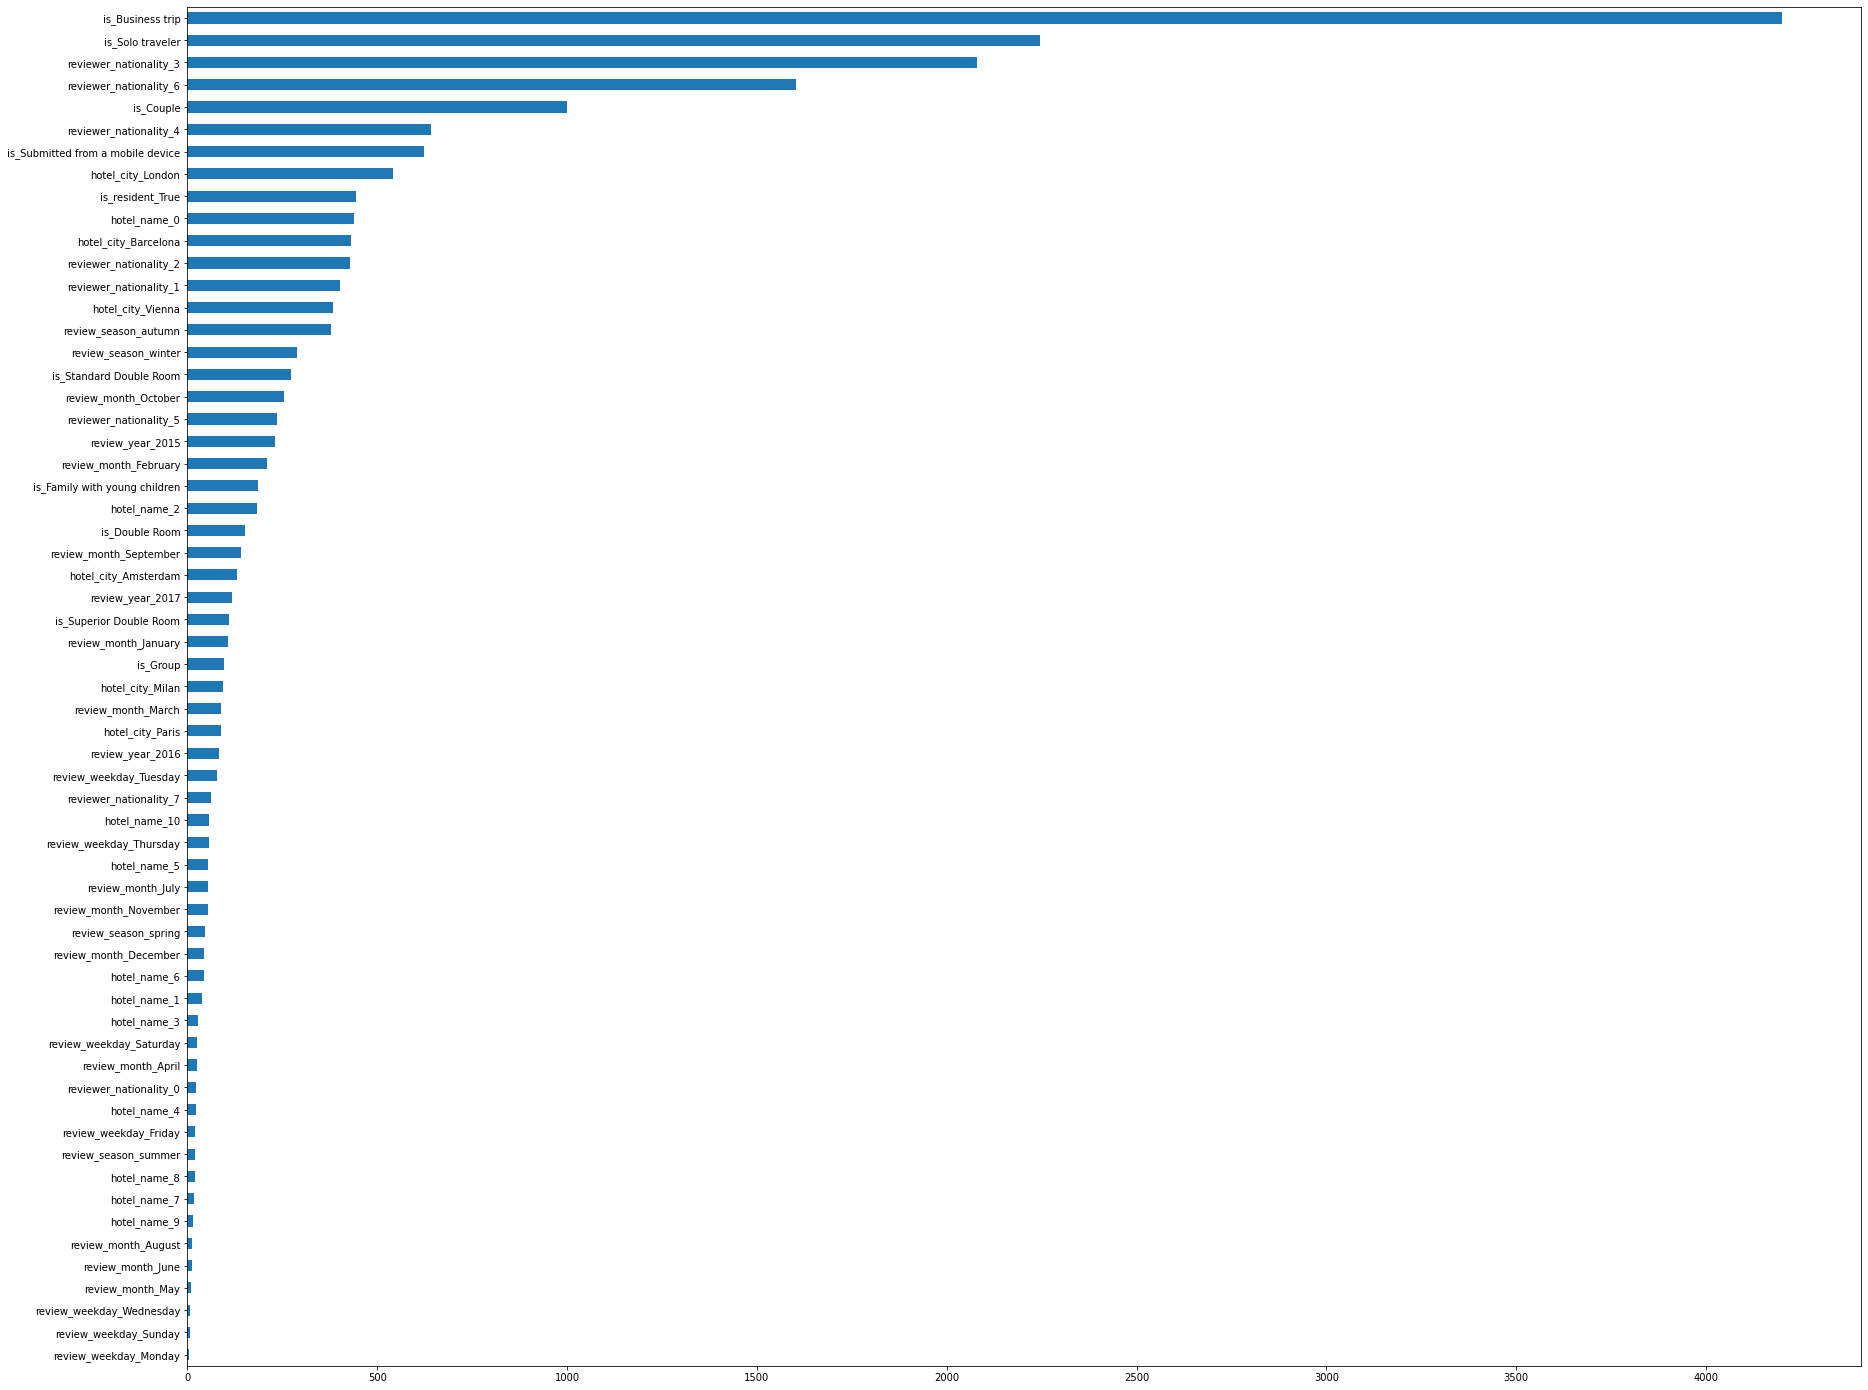

In [43]:
imp_cat = pd.Series(chi2(X[cat_features], y.astype('int'))[0], index=cat_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(30, 25))

In [44]:
# удалим признаки, которые слабо влияют на целевую переменную

cat_features_to_drop = ['review_weekday_Monday', 'review_weekday_Sunday',
       'review_weekday_Wednesday', 'review_month_May', 'review_month_June',
       'review_month_August', 'hotel_name_9', 'hotel_name_7', 'hotel_name_8',
       'review_season_summer', 'review_weekday_Friday', 'hotel_name_4',
       'reviewer_nationality_0', 'review_month_April',
       'review_weekday_Saturday']
data = data.drop(cat_features_to_drop, axis = 1)

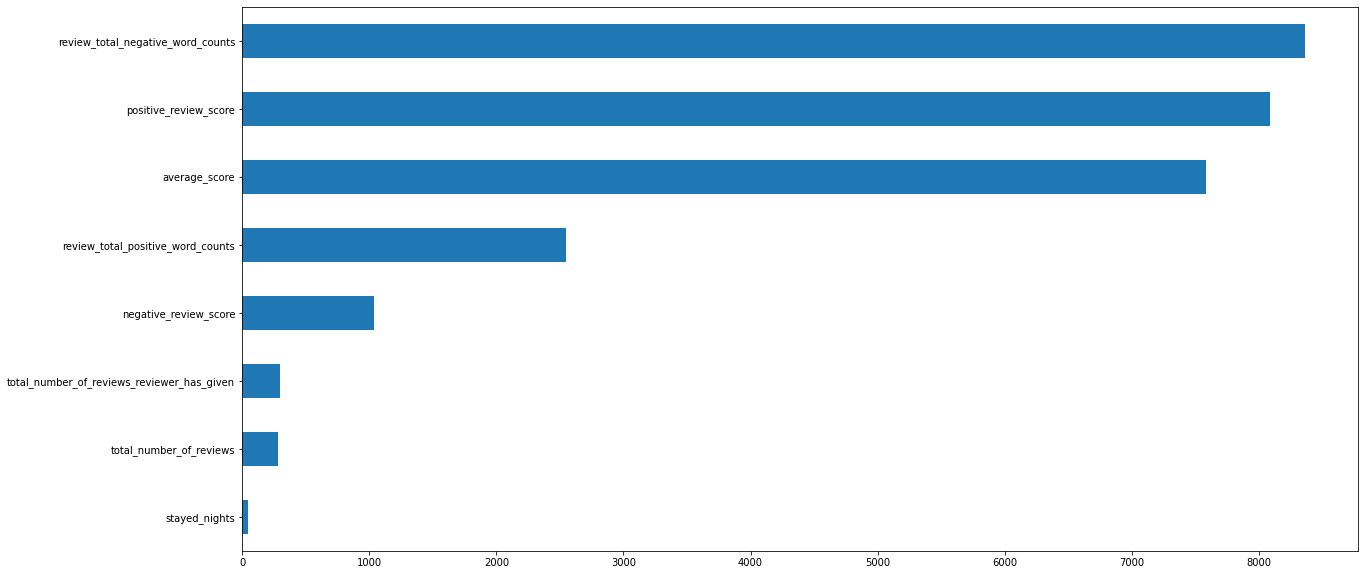

In [45]:
# теперь проведем тест ANOVA
imp_num = pd.Series(f_classif(X[num_features], y.astype('int'))[0], index = num_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind='barh', figsize=(20, 10));


In [46]:
# удалим единственные признак - stayed_nights

data = data.drop('stayed_nights', axis = 1)

Теперь можно приступать к обучению модели!

# Обучение модели

In [47]:
# Выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [48]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [49]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 54), (386496, 54), (386496, 53), (309196, 53), (77300, 53))

In [50]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [51]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [52]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [53]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8755370134294336


<AxesSubplot:>

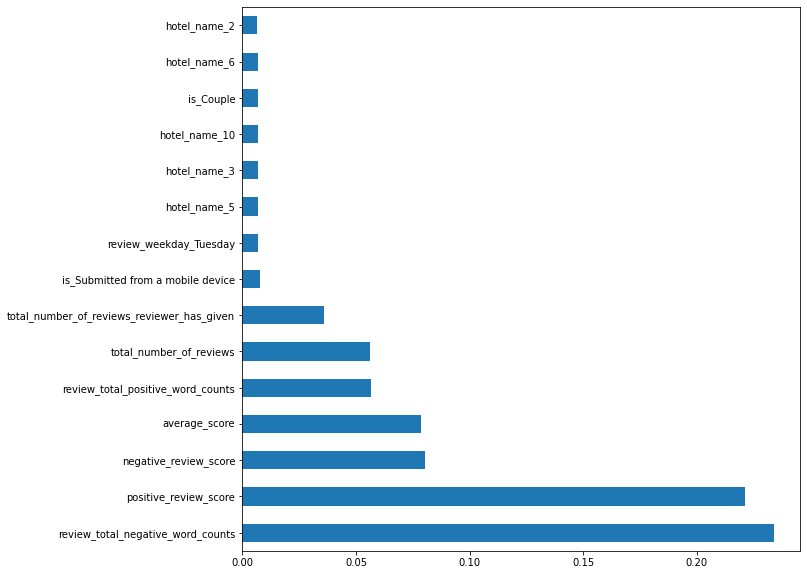

In [54]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [55]:
test_data.sample(10)

,average_score,reviewer_score,is_Submitted from a mobile device,is_Couple,is_Solo traveler,is_Business trip,is_Group,is_Family with young children,is_Double Room,is_Standard Double Room,is_Superior Double Room,positive_review_score,negative_review_score,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Milan,hotel_city_Paris,hotel_city_Vienna,is_resident_True,review_weekday_Thursday,review_weekday_Tuesday,review_month_December,review_month_February,review_month_January,review_month_July,review_month_March,review_month_November,review_month_October,review_month_September,review_year_2015,review_year_2016,review_year_2017,review_season_autumn,review_season_spring,review_season_winter,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_5,hotel_name_6,hotel_name_10,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
53049,8.9,0.0,1,0,1,0,0,0,0,0,0,0.0000,0.0000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0.004902,0.173272,0.005063,0.025424
70859,8.4,0.0,0,1,0,0,0,0,0,0,0,0.3400,-0.8155,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,0,0.080882,0.048235,0.000000,0.022599
61642,8.5,0.0,1,0,1,1,0,0,0,0,1,0.0000,0.3612,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,1,0,0.029412,0.308775,0.005063,0.016949
12039,7.8,0.0,0,1,0,1,0,0,0,0,0,0.9413,-0.7096,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,1,1,0,1,0,1,0,0,1,0.000000,0.224334,0.045570,0.031073
117761,8.1,0.0,0,0,0,0,0,1,0,0,1,0.0000,-0.4019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0.019608,0.096770,0.017722,0.000000
35317,7.8,0.0,1,1,0,0,0,0,0,1,0,0.5859,-0.0304,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0.191176,0.354965,0.053165,0.059322
93469,8.1,0.0,0,0,1,1,0,0,0,0,0,0.3400,-0.3687,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0.088235,0.572863,0.000000,0.005650
82184,8.7,0.0,0,0,1,1,0,0,0,0,0,0.8860,-0.4767,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,0,1,1,0.031863,0.137668,0.111392,0.028249
50838,8.1,0.0,1,0,1,1,0,0,0,0,0,0.5106,0.4404,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.053922,0.394840,0.020253,0.005650
11892,8.8,0.0,1,0,0,0,0,1,0,0,0,0.9621,-0.2500,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,0.026961,0.078607,0.108861,0.028249


In [56]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [57]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [58]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


In [59]:
predict_submission

array([8.716, 7.488, 8.815, ..., 8.004, 9.485, 7.109])

In [60]:
list(sample_submission)

['reviewer_score', 'id']

In [61]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.716,488440
1,7.488,274649
2,8.815,374688
3,9.742,404352
4,9.494,451596
5,9.155,302161
6,7.909,317079
7,7.824,13963
8,8.685,159785
9,7.715,195089
